In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import talib
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
close = np.random.random(100)

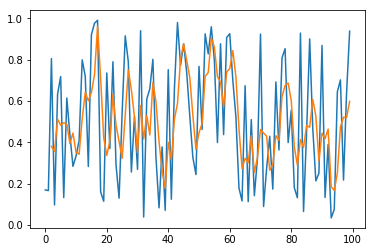

In [28]:
pd.Series(close).plot()
talib.SMA(pd.Series(close), timeperiod=3).plot()

In [ ]:
import numpy as np
import pandas as pd
import datetime
import time
import re
import talib
import operator
import psycopg2
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.header import Header

"""
自动数据库读取数据，计算排序，发送邮件
"""


# Part 1: 计算两天close涨幅 T1,T2
def zf(data):
    resdata = []
    for r in data.itertuples():
        time = getattr(r, 'time')
        open = getattr(r, 'open')
        high = getattr(r, 'high')
        low = getattr(r, 'low')
        close = getattr(r, 'close')
        resdata.append([time, open, high, low, close])
    res = [0]
    for i in range(1, len(resdata)):
        T = (float(resdata[i][4]) - float(resdata[i - 1][4])) / float(resdata[i - 1][4]) * 100
        res.append(T)
    return res


# Part 2: 计算TP和值
def myTP(T1, T2, Q):
    res = [0]

    for i in range(len(T1)):
        t = T1[i] * (1 - Q / 100) + T2[i] * (Q / 100)
        res.append(t)
    return res


# Part 3: 计算TP差值
def myTM(T1, T2, Q):
    res = [0]
    for i in range(len(T1)):
        t = T1[i] * (1 - Q / 100) - T2[i] * (Q / 100)
        res.append(t)
    return res


# Part 4: 计算和值累加 或 差值累加
def mySUM(TP):
    res = [0]
    for i in TP:
        res.append(res[-1] + i)
    return res


# Part 5: 求指定周期均值，参数1数据列表，参数2周期，返回单个数值
def myAverage(lists, tp):
    if len(lists) > tp:
        return np.mean(lists[-tp:])
    else:
        return np.mean(lists)


# Part 6: 判断趋势
def pdqs(lists):
    count = -1
    while lists[count] == lists[count - 1]:
        count -= 1
    if lists[count] > lists[count - 1]:
        return "趋势向上"
    elif lists[count] < lists[count - 1]:
        return "趋势向下"


# 判断交叉
# def pdjx(ddlist, eelist):
#     for i in range(len(ddlist)):
#         if ddlist[-i]:
#             return "金叉"
#         elif eelist[-i]:
#             return "死叉"
#         else:
#             return '没有交叉'
# Part 7: 判断交叉
def pdjx(ddlist, eelist):
    for i in range(len(ddlist)):
        if ddlist[-i]:
            return "金叉"
        elif eelist[-i]:
            return "死叉"
        else:
            return '没有交叉'


# Part 8: 计算结果 参数：数据1，数据2，短周期，长周期，权重1，权重2,截止日期
def comres(data0, data1, S, L, Q1, Q2, starttime, endtime):
    """计算两者排名"""
    pd.to_datetime(data0.ix[:, 0])  # 转换为时间格式
    pd.to_datetime(data1.ix[:, 0])  # 转换为时间格式

    # timestr = '2018-10-19 00:00:00'

    data0 = data0[(data0.ix[:, 0] <= endtime) & (data0.ix[:, 0] >= starttime)]
    data1 = data1[(data1.ix[:, 0] <= endtime) & (data1.ix[:, 0] >= starttime)]
    # print('筛选后')
    # print(len(data0), len(data1))
    T1 = zf(data0)  # 第一腿涨幅
    T2 = zf(data1)  # 第二腿涨幅

    TP = myTP(T1, T2, Q1)  # 相对和
    TM = myTM(T1, T2, Q2)  # 相对差

    TPSUM = mySUM(TP)  # 相对和累加
    TMSUM = mySUM(TM)  # 相对差累加

    TMS = np.array(TMSUM)
    TPS = np.array(TPSUM)

    MA1 = talib.MA(TMS, S)  # 相对差短周期均线
    MA2 = talib.MA(TMS, L)  # 相对差长周期均线

    # MAS = talib.MA(TPS, S)
    # MAL = talib.MA(TPS, L)

    if MA1[-1] > MA2[-1]:
        jx = '金叉'
    else:
        jx = '死叉'

    MA1qs = pdqs(MA1)
    MA2qs = pdqs(MA2)
    # print(MA2)
    # print("交叉：" + jx)
    # print("短周期相对差累加均线MA1趋势:" + MA1qs)
    # print("长周期相对差累加均线MA2趋势:" + MA2qs)
    if jx == '金叉':
        return 1
    if jx == '死叉':
        return -1

# Part 9:
def get_data(conn, sym, period):
    """获取数据"""
    if sym == 'BTC':
        sym = 'xbtusd'
    else:
        sym = sym.lower() + 'u18z18'
    sqllasttime = " SELECT time, open, high, low, close, volume from " + sym + "_" + period + " order by time"
    df = pd.read_sql(sqllasttime, con=conn)
    return df

# Part 10:
def send_email(username, password, receiver, text):
    """发送邮件"""
    smtpserver = 'smtp.qq.com'
    sender = username

    subject = '强弱排名'
    subject = Header(subject, 'utf-8').encode()

    msg = MIMEMultipart('mixed')
    msg['Subject'] = subject
    msg['From'] = username
    # msg['To'] = 'XXX@126.com'
    # 收件人为多个收件人,通过join将列表转换为以;为间隔的字符串
    msg['To'] = ";".join(receiver)
    # msg['Date']='2012-3-16'

    text_plain = MIMEText(text, 'plain', 'utf-8')
    msg.attach(text_plain)

    # 发送邮件
    smtp = smtplib.SMTP()
    smtp.connect('smtp.qq.com')
    # 我们用set_debuglevel(1)就可以打印出和SMTP服务器交互的所有信息。
    # smtp.set_debuglevel(1)
    smtp.login(username, password)
    smtp.sendmail(sender, receiver, msg.as_string())
    smtp.quit()

# Part 11:
def sleeptime(timestr):
    now_time = datetime.datetime.now()
    nowhms = time.strftime("%H:%M:%S")
    # 目标时间与今天还未到达
    if nowhms < timestr:
        now_year = now_time.year
        now_month = now_time.month
        now_day = now_time.day
        aimtime = datetime.datetime.strptime(str(now_year) + "-" + str(now_month) + "-" + str(now_day) + " " + timestr,
                                             "%Y-%m-%d %H:%M:%S")
        sleeptime = (aimtime - now_time).total_seconds()
        print('当前时间', now_time)
        print('目标时间', aimtime)
        print('睡眠时间', sleeptime)
        time.sleep(sleeptime)
    else:
        # 目标时间今天已过
        aimtime = now_time + datetime.timedelta(days=+1)
        aim_year = aimtime.year
        aim_month = aimtime.month
        aim_day = aimtime.day
        aimtime = datetime.datetime.strptime(str(aim_year) + "-" + str(aim_month) + "-" + str(aim_day) + " " + timestr,
                                             "%Y-%m-%d %H:%M:%S")
        sleeptime = (aimtime - now_time).total_seconds()
        print('当前时间', now_time)
        print('目标时间', aimtime)
        print('睡眠时间', sleeptime)
        time.sleep(sleeptime)


if __name__ == '__main__':

    acttime = '08:05:00'
    # sleeptime(acttime)

    username = '499428970@qq.com'
    password = 'oklvhkylrbtqbjja'
    sender = '499428970@qq.com'
    # receiver='XXX@126.com'
    # 收件人为多个收件人
    receiver = ['bradsun91@163.com']

    conn = psycopg2.connect(database="bitmexdata", user="postgres", password="tongKen123", host="128.199.97.202", port="5432")
    # 合约列表
    symlist = ['ADA', 'TRX', 'BCH', 'BTC', 'LTC', 'XRP', 'ETH', 'EOS']
    binSize = '1d'
    starttime = '2018-06-29 00:00:00'
    endtime = '2018-10-16 00:00:00'

    Q1 = 50  # 权重1
    Q2 = 50  # 权重2 相对差
    S = 3  # 短周期
    L = 5  # 长周期w

    with open('比较结果.txt', 'w') as f:
        f.write('')
    for i in range(len(symlist)):
        for j in range(i + 1, len(symlist)):
            sym0 = symlist[i]
            sym1 = symlist[j]
            # print(sym0 + '与' + sym1 + '比较结果如下:')
            # data0 = path + sym0 + '_' + binSize + '.csv'
            # data1 = path + sym1 + '_' + binSize + '.csv'
            data0 = get_data(conn, sym0, binSize)
            data1 = get_data(conn, sym1, binSize)
            # print(sym0, sym1)
            # print(len(data0), len(data1))
            res = comres(data0, data1, S, L, Q1, Q2, starttime, endtime)
            # print(res)

            with open('比较结果.txt', 'a') as f:
                # 金叉
                if res == 1:
                    f.write(sym0 + ',' + sym1)
                else:
                    f.write(sym1 + ',' + sym0)
                f.write('\n')

    b = np.loadtxt('比较结果.txt', dtype=np.str, delimiter=',')
    sortres = {}
    for s in symlist:
        npsum = np.sum(b[:, 0] == s)
        sortres[s] = npsum

    # print('结果字典;')
    # print(sortres)
    sorted_res = sorted(sortres.items(), key=operator.itemgetter(1), reverse=True)
    now_time = str((datetime.datetime.now() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d'))

    restext = endtime[0:10] + '\n'
    for r in sorted_res:
        restext = restext + str(r[0]) + ' ' + str(r[1]) + '\n'
    print(restext)

    # send_email(username, password, receiver, restext)
    conn.close()
